# Surprise Removal
## John R. Lawson, 2022
#### (Supporting material for paper in preparation)
##### Coauthors: Corey K. Potvin and Kenric Nelson. Code by JRL. 
##### Work supported by CIMMS/NSSL, Oklahoma; and Valparaiso University, Indiana, USA.


In [1]:
import pdb
import itertools
import sys
import os
import multiprocessing
import random
import copy
import pickle

import sklearn
import sklearn.preprocessing
import sklearn.decomposition
from scipy.stats import gmean as geomean
import matplotlib as M
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

np.set_printoptions(precision=4,suppress=True)
pd.set_option("display.precision",4)
pd.set_option("display.float_format",'{:.4f}'.format)
np.random.seed(27)
ncpus = 3
%matplotlib inline

# Shortcut for fonts
ff = {'fontname':"Ubuntu"}

## The problem
We desire to reduce uncertainty about future events as much as possible. For weather forecasts and related scientific communication to end-users, we aim to minimise forecast error, or maximise our information gain, for predicting hazards. The information required to determine an outcome is determined by the frequency of its occurrence, or its surprisal: 

$$
S = -\log_2(f)
$$

where $f$ is the probability of an event occurring. Herein, we are concerned with a binary probabilistic forecast, where we will mask a time series past a percentile threshold to create a set of Trues and Falses.  Hence with two categories $n=2$, we form an array of probabilities $\mathbf{f}$ where each sample is denoted by $\alpha \in \{1,2,...,N_\alpha \}$. First we consider only one sample, as the following scores are __scoring rules__ and can be applied to any number of samples $N_\alpha \in \mathbb{Z}^+$. The two categories are $\mathbf{f} = (1-f,f)$, with each element denoted by $i \in \{1,2,...,n\}$; then average surprise provides a measure of uncertainty in $\mathbf{f}$ when we summate the possibilities with their probabilities:

$$
H(f) = \underbrace{(1-\mathbf{f}) \log_2(1-\mathbf{f})}_{\textrm{Event did not occur}} + \underbrace{\mathbf{f} \log_2(\mathbf{f})}_{\textrm{Event occurred}} \\
= \sum^{n}_{i=1} \mathbf{f}_i \log_2 \mathbf{f}_i \\
= \mathsf{E}[S(\mathbf{f})]
$$

where the expectation operator $\mathsf{E}[~]$ is shorthand for the mean outcome in the limit of time. Above, Shannon entropy $H$, here in bits due to the base-2 logarithm, represents the uncertainty in a time series that must be removed. For comparison, flipping a fair coin resolves *one bit* of uncertainty. Notice that a low value of $H$ but high $S$ occurs when focussing on a given rarer event, because the assumption of "no event" is successful more times than not. In meteorology, we can use this score to estimate how much uncertainty is removed by a given forecast by differencing the uncertainty before and after a forecast is obtained. This change in estimated likelihood is measured by the Kullback-Liebler Divergence $D_{\textrm{KL}}$, which is the uncertainty or surprise (entropy) remaining after a forecast is issued, upon verification from observation $\mathbf{o} = (1-o,o)$:

$$
D_{\textrm{KL}}(\mathbf{o}\|\mathbf{f}) = \sum^{n}_{i=1} \mathbf{o}_i \log_2 \frac{\mathbf{o}_i}{\mathbf{f}_i}
$$

For reference, for one event this can be expanded to

$$          
D_{\textrm{KL}}(o\|f) = (1-o) \log2 \frac{(1-o)}{(1-f)} + o \log_2 \frac{o}{f}
$$

Variations of this score occur under various names, including Ignorance (ref), the logarithm score (ref), etc. Herein, we implement $D_\textrm{KL}$ within the Cross-Entropy Score (XES, ref), using cross-entropy $H_\times$ which extends $D_\textrm{KL}$ to include observational uncertainty. We also extend to 2-D forecast and observation arrays with $N_\alpha > 1$:

$$
H_\times(\mathbf{o},\mathbf{f}) = D_{\textrm{KL}}(\mathbf{o}\|\mathbf{f}) + H(\mathbf{o}) \\ \hspace{1cm}
\textrm{XES} \equiv H_\times (\mathbf{o},\mathbf{f}) \hspace{2cm} \\
= -\frac{1}{N_\alpha} \sum^{N_\alpha}_{\alpha=1} \sum^{n}_{i=1} \mathbf{o}_{\alpha,i} \log_2 \mathbf{f}_{\alpha,i}
$$

Note that each forecast--observation pair $\alpha$ (epochs; observations; timesteps) may be distinct from the real-world time $\tau$. Often, observations are assumed to be perfect: $o \in \{0,1\}$. We will assume so in the current paper; however, XES allows fractional probabilities to represent observational uncertainty. 

# Brier Score versus Cross-Entropy Score

This reduces to "Mean Square Error" versus "Cross-Entropy" as measures of distances between the forecast and observation probability distributions. Perhaps due to the computational resources required to compute logarithms (Harold Brooks, pers. corr.), the mean squared error or __Brier Score__ is (ref) often used in meteorology:

$$
\textrm{BS} = \frac{1}{N_\alpha} \sum_\alpha^{N_\alpha}  (\mathbf{f}-\mathbf{o})^2
$$


Hence, the XES in one-term form (i.e., not DKL) for two events (say, rain or no-rain) is:

$$
\textrm{XES} = o \log_2 f - (1-o) \log_2 (1-f) \\
$$

However, for forecasts of rare events (<10\%), the Brier Score deviates substantially from the "true" measure of information gained. Benedetti (2010) showed that BS was a second-order approximation of XES (cf. above with their eqs. 27--31), where the biggest differences between the two scores occurred at extreme probabilities (near zero and unity). As in Benedetti, we can show this mathematically by first expanding the Brier Score for one event, with for forecast and observed probabilities $f$ and $o$ respectively.

We demonstrate the scenarios where largest differences occur between BS and XES practically by comparing the scores, first normalising each score by a measure of uncertainty so we can compare like-for-like __skill scores__. (This is shown mathematically below the figure). Skill scores are preferred over the un-normalised score, as they are independent of the observational uncertainty $H(\mathbf{o})$. We plot BSS and XESS for $f \in [0.01,0.99]$ when the observed frequency $o \in \{0.1,0.3,0.5\}$. __Forecast probabilities must be bounded to minimum and maximum probabilities__ $[ \underline{p},\bar{p} ]$ to avoid divergence to infinity, but also to avoid full confidence in the face of underdispersion (overfitting). We also set $\log_2 0 = 0$. A positive value indicates better skill than climatology.

Quote from Wikipedia regarding Benedetti paper: "The Brier score becomes inadequate for very rare (or very frequent) events, because it does not sufficiently discriminate between small changes in forecast that are significant for rare events. Wilks (2010) has found that "...quite large sample sizes, i.e. n > 1000, are required for higher-skill forecasts of relatively rare events, whereas only quite modest sample sizes are needed for low-skill forecasts of common events."


In [2]:
class BrierScore:
    def __init__(self,f,o,fk=None):
        self.o = o
        self.f = f
        
        if fk == None:
            self.fk = np.unique(self.f) 
        else:
            self.fk = fk
            
    @staticmethod
    def do_mean(x):
        if isinstance(x,(float,int)):
            return x
        else:
            return np.mean(x)

    def compute_BS(self,from_components=False):
        if from_components:
            REL = self.compute_REL()
            RES = self.compute_RES()
            UNC = self.compute_UNC()
            return 
        else:
            return self.do_mean((self.f-self.o)**2)
    
    @staticmethod
    def single_BS(f,o):
        """No observational error!
        
        For use when decomposition can't be performed, and single values
        are needed.
        """
        return (f-o)**2
    
    @classmethod
    def single_BSS(cls,f,o):
        """No observational error!
        """
        BS = cls.single_BS(f,o)
        BS_UNC = cls.single_UNC(f,o)
        BSS = (BS-BS_UNC)/(0-BS_UNC)
        return BSS

    @staticmethod
    def single_UNC(f,o):
        """No observational error!
        """
        return o*(1-o)
        
    def compute_UNC(self):
        return self.do_mean(self.o) * (1-self.do_mean(self.o))
          
    def compute_REL(self):
        """ Compute reliability.
        """
        rel = np.zeros_like(self.fk)
        for nk,k in enumerate(self.fk):
            ok = self.o[self.f==k]
            ok_bar = self.do_mean(ok)
            rel[nk] = ok.size * ((k-ok_bar)**2)
        REL = np.sum(rel)/self.o.size
        return REL

    def compute_DSC(self):
        # p_o  : frequency of observation for this k
        dsc = np.zeros_like(self.fk)
        for nk,k in enumerate(self.fk):
            ok = self.o[self.f==k]
            ok_bar = self.do_mean(ok)
            o_bar = self.do_mean(self.o)
            dsc[nk] = ok.size * ((ok_bar-o_bar)**2)
        DSC = np.sum(dsc)/self.o.size
        return DSC
    
    def compute_BSS(self,from_components=False,return_all=False):
        BS_UNC = self.compute_UNC()
        BS = self.compute_BS(from_components=from_components)
        BSS = (BS-BS_UNC)/(0-BS_UNC)
        return BSS



In [3]:
class InfoGain:
    """ For computing and visualising skill scores for a probabilistic forecast.
    Currently for two categories (binary) only, but with observational error. 
    """
    def __init__(self,f,o,fk=None):
        """ Initialise the suite.
        Args:
        f:  1-D prob forecasts [0,1]. The probabilities should be bounded to 
                  avoid divergence to infinity
        o:  1-D obs forecast [0,1], may or may not include obs uncertainty
        fk: 1-D array of probability levels. If None, compute automatically.
        """
        self.f = f
        self.o = o
        self.logbase = 2 
        
        if fk == None:
            self.fk = np.unique(self.f) 
        else:
            self.fk = fk 
            
    @staticmethod
    def do_geomean(n):
        # if isinstance(n,(np.float,float,np.int,int)):
        # pdb.set_trace()
        if isinstance(n,(float,int)):
            return n
        else:
            return geomean(n)
    
    @staticmethod
    def compute_DKL(x,y,return_all=False):
        """ Kullback-Liebler Divergence

        Args:
        x   : 1-D (e.g., observations)
        y   : 1-D (e.g., forecasts)
        """            
        with np.errstate(divide='ignore',invalid='ignore'):
            # Enforce array so we can remove nans
            term1 = np.array(((1-x) * np.log2((1-x)/(1-y))))
            term2 = np.array((x * np.log2(x/y)))
        
        term1[x==1] = 0
        term2[x==0] = 0
        
        DKL_all = term1 + term2
        DKL = np.mean(DKL_all)
        if return_all:
            return DKL, DKL_all
        return DKL
    
    def compute_XESS(self,with_H=True,from_components=False):
        UNC = self.compute_UNC()
        XES = self.compute_XES(with_H=with_H)
        XESS = (XES-UNC)/(0-UNC)
        return XESS
    
    @staticmethod
    def compute_entropy(x,return_all=False):
        """ Average surprise. A series of surprise
        values are returned if return_all is True.
        
        Is this right? Surprise v UNC?
        
        """
        H_all = (-(1-x) * np.log2(1-x)) + -(x * np.log2(x))
        # H_all = ((1-x) * np.log2(1-x)) - (x * np.log2(x))
        H = np.mean(H_all)
        if return_all:
            return H, H_all
        return H
    
    def compute_H(self):
        """Return entropy of the observation field.
        """
        return self.compute_entropy(self.o)
    
    def compute_XES(self,with_H=True,from_components=False,return_all=False):
        """ Cross-entropy score.

        Args:

        """
        if with_H:
            if return_all:
                H, H_all = self.compute_H(return_all=True)
            else:
                H = self.compute_H()
            
        if from_components:
            REL = self.compute_REL()
            DSC = self.compute_DSC()
            UNC = self.compute_UNC()
            if with_H:
                XES = REL-DSC+UNC+H
            else:
                XES = REL-DSC+UNC
        else:        
            if return_all:
                XES, XES_all = self.compute_DKL(self.o,self.f,return_all=True)
            else:
                XES = self.compute_DKL(self.o,self.f)
                
            if with_H:
                XES += H
                if return_all:
                    XES_all += H_all
                    return XES, XES_all
            
        return XES
    
    @staticmethod
    def single_XES(f,o):
        """No observational error!
        """
        return ((1-o)*np.log2((1-o)/(1-f)))+(o*np.log2(o/f))
          
    @classmethod
    def single_XESS(cls,f,o):
        """No observational error!
        """
        XES = cls.single_XES(f,o)
        XES_UNC = cls.single_UNC(f,o)
        XESS = (XES-XES_UNC)/(0-XES_UNC)
        return XESS

    @staticmethod
    def single_UNC(f,o):
        """No observational error!
        """
        return (-o*np.log2(o))-((1-o)*np.log2(1-o))

    def compute_DSC(self):
        dsc = np.zeros_like(self.fk)
        for nk,k in enumerate(self.fk):
            ok = self.o[self.f==k]
            ok_hat = self.do_geomean(ok)
            o_hat = self.do_geomean(self.o)
            dsc[nk] = ok.size * self.compute_DKL(ok_hat,o_hat)
        DSC = np.sum(dsc)/self.o.size
        return DSC
    
    def compute_REL(self):
        rel = np.zeros_like(self.fk)
        for nk,k in enumerate(self.fk):
            ok = self.o[self.f==k]
            ok_hat = self.do_geomean(ok)
            rel[nk] = ok.size * self.compute_DKL(ok_hat,k)
        REL = np.sum(rel)/self.o.size
        return REL
            
    def compute_UNC(self):
        """ Compute uncertainty component of the forecast.
        """
        p_o = self.do_geomean(self.o)
        # with np.errstate(divide='ignore',invalid='ignore'):
        term1 = -p_o*np.log2(p_o)
        term2 = (1-p_o)*np.log2(1-p_o)
        UNC = term1 - term2
        return UNC 

    @staticmethod
    def bound(x,thresh="auto",Ne=None):
        if (thresh == "auto"):
            thresh = 1/(3*Ne)
        else:
            assert isinstance(thresh,(float,np.float))
        x[x<thresh] = thresh
        x[x>(1-thresh)] = 1-thresh
        return x 
    
    def count_bin_size(x,fk):
        """From Wilks: need to bin fcst probs, setting the middle of
        the bin as the value...

        """
        bin_counts,bin_edges = np.histogram(x,bins=fk)
        return bin_counts

    def quantise(x,fk):
        # I think the index is not right, need to look at bin edges?
        quant_probs = np.digitize(x,fk)
        # pdb.set_trace()
        f = [fk[q-1] for q in quant_probs]
        return f



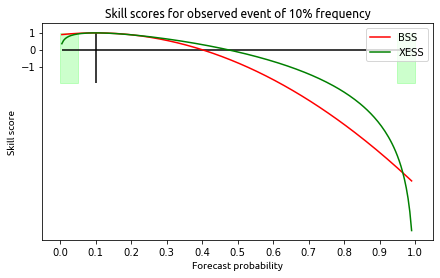

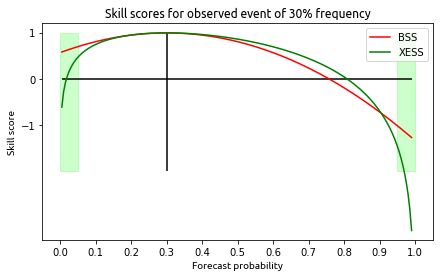

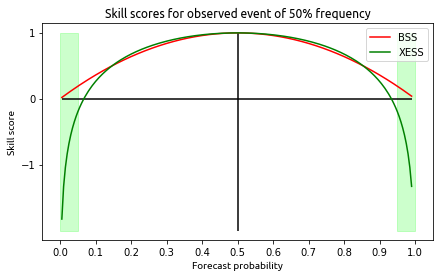

In [4]:
def plot_BSSvXESS(f,BSS,XESS):
    fig,ax = plt.subplots(1,figsize=(7,4))
    
    ax.plot(f,BSS,label='BSS',zorder=3,color="red",linestyle='-')
    ax.plot(f,XESS,label='XESS',zorder=3,color="green",linestyle="-")
    
    ax.legend()
    ax.hlines(y=0,xmin=f.min(),xmax=f.max(),color='k',
              zorder=2)
    ax.vlines(x=o,ymin=-2,ymax=1,color='k',zorder=2)
    ax.set_xlabel('Forecast probability',**ff)
    ax.set_ylabel('Skill score',**ff)
    ax.set_title(f"Skill scores for observed event of {int(o*100):d}% frequency",**ff)
    ax.set_yticks([-1,0,1])
    ax.set_xticks(np.arange(0.0,1.1,0.1))

    ax.fill_between(x=[0,0.05],y1=[-2,-2],y2=[1,1],
                    zorder=1,color='lime',alpha=0.2)
    ax.fill_between(x=[0.95,1],y1=[-2,-2],y2=[1,1],
                    zorder=1,color='lime',alpha=0.2)
    display(fig)
    plt.close(fig)

f = np.arange(0.005,0.995,0.005)

for o in (0.1,0.3,0.5):  
    BSS = BrierScore.single_BSS(f,o)
    XESS = InfoGain.single_XESS(f,o)
    plot_BSSvXESS(f,BSS,XESS)

The lowest 5% forecast probabilities are highlighted in green. We see the slopes of the curves diverge markedly at the extreme probabilities. (i.e., the change in skill estimation with absolute probability error for a very rare or very common event). Also, BSS goes into negative (skill is lost) at different locations to XESS, meaning the two scores are not interchangeable at the extremes. __So how do we pick one?__ 

# Derivation of cross-entropy components

So let's look more in depth at how the score behaves for predictions of rare, intermittent events forecast by an ensemble forecasting system (EFS) comprising $N_e$ members. Probabilities will be generated from the multiple integrations with small perturbations in the initial conditions (i.e., we assume a perfect model.) by performing the mean over the vector $\mathbf{f}$ of Trues and Falses in the forecast at each $\alpha$. Just like the Brier Score (ref), the XES can be decomposed (e.g., ref) into four different quantities as: 

$$
\textrm{XES} = \underbrace{\frac{1}{N_\alpha} \sum^{N_k}_{k=1} n_k D_\textrm{KL} (\mathbf{\hat{o}_k} \| \mathbf{f_k}) }_\textrm{Reliability (REL)} - 
\underbrace{ \frac{1}{N_\alpha} \sum^{N_k}_{k=1} n_k D_\textrm{KL} (\mathbf{\hat{o}_k} \| \mathbf{\hat{o}}) }_\textrm{Discrimination (DSC)} + 
\underbrace{ \frac{1}{N_\alpha} \sum^{N_\alpha}_{\alpha=1} D_\textrm{KL} (\mathbf{o_\alpha} \| \mathbf{\hat{o}}) }_\textrm{Uncertainty (UNC)} + 
\underbrace{ \frac{1}{N_\alpha} \sum^{N_\alpha}_{\alpha=1} H(\mathbf{o_\alpha}) }_\textrm{Obs. Uncertainty} \\ \hspace{1cm} \\
\forall k \in \{ \underline{p},\frac{1}{N_e},\frac{2}{N_e},...,\frac{N_e-1}{N_e},\bar{p} \}
$$

where $k$ is each probability level. The components DSC, REL, and UNC represent discrimination, reliability, and uncertainty:

* Discrimination, DSC, is a measure of useful information gained, sometimes termed "inherent goodness". Also known as mutual information between forecasts and observations. Higher values are better.
* Reliability, REL, is a measure of the "probabilistic false alarm", or the amount of information that proved detrimental to reducing surprise. In EFSs, this stems from, e.g., issuing a 30% chance of rain before 20% of the observed rain events. Lower values are better.
* Uncertainty, UNC, is the portion of missing information that is inherent and inextricable to the system. This itself comprises both (1) observational error (2) and inherent uncertainty in the system regardless of observational error from chaotic error growth (exponential information loss). Lower values indicate higher predictability (lower inherent uncertainty).

Both DSC and REL can be divided by UNC to create skill-score components - like the XESS, this is neither a proper score (ref) nor measured in bits, but it gives a normalised approximation. Unlike XESS, DSCSS and RELSS are positive values.

The Brier Score can be written in components analogously as:

$$
\textrm{BS} = \underbrace{\frac{1}{N_\alpha}\sum\limits _{k=1}^{N_k}{n_{k}(\mathbf{f_{k}}-\mathbf{\bar{o}}_{\mathbf{k}})}^{2}}_\textrm{Reliability (REL)} - \underbrace{\frac{1}{N_\alpha}\sum\limits _{k=1}^{N_k}{n_{k}(\mathbf{\bar{o}_{k}}-\bar{\mathbf{o}})}^{2}}_\textrm{Discrimination (DSC)} + \underbrace{\mathbf{\bar{o}}\left({1-\mathbf{\bar{o}}}\right)}_\textrm{Uncertainty (UNC)} + \textrm{Obs Unc.}
$$

A rarer phenomenon has less average surprise (the assumption of "no event" is usually correct), but a much larger surprise when it occurs without being forecast. Hence, there is less uncertainty to resolve, averaged over the dataset, for a rarer event. We must therefore normalise the estimate of skill by the entropy of the observations, or the UNC component. We name this the Cross-Entropy Skill Score in analogy to (Weijs et al ref):

$$
\textrm{XESS} = \frac{\textrm{DSC}}{\textrm{UNC}} - \frac{\textrm{REL}}{\textrm{UNC}} \\
= \frac{\textrm{XES}-\textrm{UNC}}{0-\textrm{UNC}} 
$$

To recapitulate: $H_\times$ measures how many bits of missing information remain after a forecast is obtained, but XESS is a normalised measure whereby positive values indicate forecast skill that outperforms the use of the climatological mean. We might preserve the time-series of individual $D_\textrm{KL}$ values in the above component equations. For rare and impactful events, the event itself may contribute very little to values averaged over a long time. This can be considered by attributing larger value to the most impactful events (i.e., where the event was observed; this mimicks societal preference for false alarms over missed hits). Here is an information-theoretical analogue of the 2x2 contingency table (confusion matrix) developed by (Green and Swets), where each box indicates the gain or loss of information in terms of surprise. We convert the probabilistic forecast into binary by setting $o$ to True if greater than 0.5, and False otherwise; a forecast is True if $f$ is greater than the end-user's critical probability $p_\textrm{cric}$, above which the user takes action such as damage mitigation:

| | $f > p_{\textrm{crit}}$ | $f < p_{\textrm{crit}}$ |
| --- | --- | --- |
| $o > 0.5$ | $+S$ | $-S(p)$ |
| $o < 0.5$ | 0 | $+S(1-p)$ |

Insufficiently accurate initial conditions, and erroneous models, mean that we will waste resources past a quantisation (resolution) level where observational error becomes substantial. This is the curse of dimensionality. Probability space is also insufficiently sampled: there will always be regions of phase space not explored by the EFS, plus an operational model is not perfect. (Herein, we use a perfect L63 model, but perturbations can be added during the integration to simulate model-error drift.) Further, smaller spatial and time scales require more information to determine its state. Hence, at finer spatial resolutions (which come with finer temporal resolutions due to the CFL criterion), more members are required to capture the larger information dimension of the pdf, or a kernel dressing should be applied to interpolate the pdf between members (refs). 

Next, we:
* Generate example time-series observations and forecasts using the Lorenz-63 model (ref) to analyse information gain estimates with respect to:
    - Intermittency ("burstiness" of the rare event)
    - Ensemble membership
    - Temporal quantisation
    - Initial-condition uncertainty of the EFS

We deploy Lorenz's 1963 three-variable model of convection (L63;ref) in an intermittent regime (i.e., extreme events come in infrequent bursts). We will create three ensembles, each varyign the $\rho$ parameter from L63. We will also consider different levels of exceedence in the L63 z-variable time series, affecting the event frequency.








In [5]:
# double approx help from github user kendixon

class L63:
    def __init__(self,x0,y0,z0,rho,
                 sigma=10.0,beta=2.667,dt=1e-3):
        """Chop off spin-up time?
        
        TODO:
            * Remove spin-up time (transients)
            * Add perturbations (with random seed allowed as arg)
        the paper values use the intermittent regime
        
        rho
        166.08 is intermittent
        166.1 is the (more intermittent) variation
        28.0 is the lorenz default
        """
        self.sigma = sigma
        self.rho = rho
        self.beta = beta
        self.dt =dt
        self.t = 0.0

        # The data array in x,y,z. Time appended in axis=3
        self.output = np.zeros((3,1))
        self.output[:,0] = [x0,y0,z0]
        # self.

    def dxdt(self,x,y):
        return self.sigma * (y-x)
    def dydt(self,x,y,z):
        return x * (self.rho - z) - y
    def dzdt(self,x,y,z):
        return (x*y) - (self.beta * z)
    
    def double_approx(self,x,y,z):
        dx1 = self.dxdt(x,y)*self.dt + x
        dy1 = self.dydt(x,y,z)*self.dt + y
        dz1 = self.dzdt(x,y,z)*self.dt + z
        
        dx2 = self.dxdt(dx1,dy1)
        dy2 = self.dydt(dx1,dy1,dz1)
        dz2 = self.dzdt(dx1,dy1,dz1)
        
        x2 = self.dt*(0.5*dx1 + 0.5*dx2) + x
        y2 = self.dt*(0.5*dy1 + 0.5*dy2) + y
        z2 = self.dt*(0.5*dz1 + 0.5*dz2) + z
        
        return x2,y2,z2
        
    def integrate_once(self,):
        """
        Args:
            t0    : Initial time
            y0    : Intiial state
        """
        x = self.output[0,-1]
        y = self.output[1,-1]
        z = self.output[2,-1]
        # print(x,y,z)
        ret = self.double_approx(x,y,z)
        # print(ret)
        new_time = np.expand_dims(np.array(ret),axis=1)
        return new_time
        
    def integrate(self,n,clip=None):
        # Time 0 is already done
        for n in range(n-1):
            next_data = self.integrate_once()
            # print(self.output.shape,next_data.shape)
            self.output = np.concatenate((self.output,next_data),axis=1)
            # print(self.output)
        #print(self.output)
        if clip is not None:
            self.output = self.output[:,clip:]
            # cut_nt = nt - clip
        return 
    
    def get_z(self,):
        return self.output[2,:]

    def get_exceedence_ts(self,pc,vrbl='z'):
        data = self.get_z()
        exceed = self.get_pc_exceed(data,pc)
        return exceed
    
    @staticmethod
    def get_pc_exceed(ts,pc):
        return ts > np.percentile(ts,pc)
    
    @staticmethod
    def do_windowing(ts,wsize):
        """
        Args:
        ts    : time series of raw data.
        wsize : epoch window size in time steps
        """
        nt = ts.size
        epochs = np.zeros(int(nt/wsize)+1).astype(bool)
        widx = np.arange(0,nt,wsize)
        windows = np.zeros_like(ts).astype(bool)
        epoch_idx = np.arange(int(wsize/2),nt,wsize)
        for nc,cidx in enumerate(widx):
            idx0 = int(nc*wsize)
            idx1 = int(idx0 + wsize)
            this_window = ts[idx0:idx1]
            epochs[nc] = True in this_window
            windows[idx0:idx1] = bool(epochs[nc])    
        return windows        
    
    @classmethod
    def mask_and_window(cls,arr,pc,wsize):
        if arr.ndim == 1:
            nt = arr.size
            arr = arr.reshape(1,nt)
        pc_arr = cls.get_pc_exceed(arr,pc)
        window_ts = np.zeros_like(pc_arr)
        for ne in range(pc_arr.shape[0]):
            window_ts[ne,:] = cls.do_windowing(pc_arr[ne,:],wsize)
        # window_ts = cls.do_windowing(pc_ts,wsize)
        return window_ts


We use the z-component (in L63, this represents rising motion in convective cells) as our time series. We convert to a binary forecast by identifying where the time series exceeds the given percentile. We then quantise in time to both introduce tolerance and mimic EFS real-world output.

* The parameter $\rho$ controls the intermittency (burstiness), which through chaotic growth (see Lyapunov exponents) destroys information about the state of the system until no further information can be obtained. This asymptote is an analogue of Lorenz's predictability limit after error saturation.
* Window size $w$ mimicks the time- and spatial-scale-aware quantisation methods used by verification scores such as Fractions Skill Score (refs). Within each overlapping window segment, moved to centre on each data point from the raw time series, we assign True for that $\alpha$ if the percentile is exceeded for that member or observation; False otherwise. This avoids verifying the noisy sample-by-sample evaluation, which is analgous to evaluating a weather model at the truncated scale (i.e., gridpoint-to-gridpoint). It also reflects the tolerance for false alarms over missed hits. The larger the value of $w$, the more likely a forecast captures the event, but the less information is transferred about the precise time of occurrence when interpreted in real-time $\tau$. Hence we may expect an optimised sweet-spot.
* The larger the percentile, the rarer the event. Coupled with the variation in regime via $\rho$, this generally represents the forecast challenge of rare, intermittent (bursty) events such as supercell outbreaks.
* We run 200 ensemble members ($N_e = 200$), but subsample randomly to create smaller ensembles of various sizes. This will assess the benefit of increasing the required computer resources linearly despite diminishing returns: each additional member contains more mutual information with the rest of the EFS members, meaning increasingly less novel (correct) information is acquired), and increasingly more incorrect information. Hence we may expect a sweet-spot.
* We perturb initial conditions with a range of small perturbations from a uniform distribution to reflect initial condition uncertainty. As these perturbvations increase in magnitude, predictability is lost more quickly (information gain cumulates over time logarithmically). However, no perturbations at all would defeat the purpose of an EFS. Hence, we expect another sweet-spot.

The high number of permutations of the above parameters mean we aggregate over all other parameters for each given parameters: this is not rigorous but will show the variability of information gain (and BSS versus XESS) as a function of $\rho$, $w$, percetile, and $N_e$.

In [6]:
def generate_z_ts(x0,y0,z0,rho,nt_all,cutoff):
    lorenz = L63(x0,y0,z0,rho=rho)
    lorenz.integrate(nt_all,clip=cutoff)
    return lorenz.get_z()

def make_itr(tweak_max,Ne):
    tweaks = np.random.uniform(-tweak_max,tweak_max,Ne)
    for ne, tweak in enumerate(tweaks):
        yield x0+tweak, y0+tweak, z0+tweak, rho

def do_run(i):
    x0,y0,z0,rho = i
    lorenz = L63(x0,y0,z0,rho)
    lorenz.integrate(nt_all,clip=cutoff)
    return lorenz.get_z()

def generate_ensemble(x0,y0,z0,Ne,rho,tweak_max,nt_all,cutoff):
    itr = make_itr(tweak_max,Ne)
    if ncpus == 1:
        ensemble = np.zeros([Ne,nt_all-cutoff])
        for n,i in enumerate(itr):
            print(f"Computing member {n} of {Ne}")
            ensemble[n,:] = do_run(i)
    else:
        with multiprocessing.Pool(ncpus) as pool:
            returns = pool.map(do_run,itr)
        ensemble = np.array(returns)
    return ensemble
                      

In [7]:
# Want truth to be window size 100?
# Then test with 200,500 window size

# Catalogue of runs
# first idx is obs, rest is fcst 


# Do numerous "days" for a longer experiment?

# Parallelisation?
# Initial conditions
x0 = 1.0
y0 = 1.0
z0 = 1.0

# Total integration steps
nt_all = 25000

# Spin-up period to be removed
cutoff = 15000

# Window size for scale-aware
# Can do later when computing scores
# wsize = 500 

# Number of ensemble members
# Can subset later
Ne = 200

# Number of time steps in raw data after spin-up is cut off
nt = nt_all - cutoff

# Measure of intermittency
rho_list = [166.08,166.09,166.1]
# percentiles for thresholding
pc_list = [93.5,95.5,97.5,98.5,99.5,99.9]
# IC perturbations for ensembles
tweak_max_list = [1e-8,1e-7,5e-7,1e-6,1e-5] 

# wsize = 100 will be minimum (i.e. truth)
wsize_list = [25,50,100,250,500,1000]

# Raw
OBS = {r:{} for r in rho_list}
FCST = {r:{t:{} for t in tweak_max_list} for r in rho_list}

# Windowed and percentile-masked
OBS_PW = {r:{pc:{w:0 for w in wsize_list} for pc in pc_list} 
                for r in rho_list}
FCST_PW = {r:{t:{pc:{w:0 for w in wsize_list} for pc in pc_list}
                for t in tweak_max_list} for r in rho_list}
    
for rho, tweak_max in itertools.product(rho_list,tweak_max_list):
    obs_file = f'data/obs_{int(rho*1000)}.npy'
    fcst_file = f'data/fcst_{int(rho*1000)}_{int(tweak_max*1e8)}.npy'
    print(fcst_file)

    # Create observation data (only once per IC perturbation value (tweak_max))
    if tweak_max == tweak_max_list[0]:
        if os.path.exists(obs_file):
            OBS[rho] = np.load(obs_file)
        else:
            obs = generate_z_ts(x0,y0,z0,rho,nt_all,cutoff)
            OBS[rho] = obs.reshape(1,obs.size)
            np.save(arr=obs,file=obs_file)

        for pc, wsize in itertools.product(pc_list,wsize_list):
            ts_pw = L63.mask_and_window(OBS[rho],pc,wsize)
            OBS_PW[rho][pc][wsize] = ts_pw
    
    # Create forecast data
    if os.path.exists(fcst_file):
        FCST[rho][tweak_max] = np.load(fcst_file)
    else:
        if __name__ == "__main__":
            fcst = generate_ensemble(x0,y0,z0,Ne,rho,tweak_max,nt_all,cutoff)
        FCST[rho][tweak_max] = fcst
        np.save(arr=fcst,file=fcst_file)
            
    for pc, wsize in itertools.product(pc_list,wsize_list):
        ts_pw = L63.mask_and_window(FCST[rho][tweak_max],pc,wsize)
        FCST_PW[rho][tweak_max][pc][wsize] = ts_pw
        
# [Ne x Nt]

data/fcst_166080_1.npy
data/fcst_166080_10.npy
data/fcst_166080_50.npy
data/fcst_166080_100.npy
data/fcst_166080_1000.npy
data/fcst_166090_1.npy
data/fcst_166090_10.npy
data/fcst_166090_50.npy
data/fcst_166090_100.npy
data/fcst_166090_1000.npy
data/fcst_166100_1.npy
data/fcst_166100_10.npy
data/fcst_166100_50.npy
data/fcst_166100_100.npy
data/fcst_166100_1000.npy


Below is an example of the first two EFS members for $\rho = 0$, $\textrm{ws} = 0$, exceeding a XXth percentile.

In [8]:
def plot_example(raw_obs,obs_pw,raw_fcst,fcst_pw,pc,wsize,title,nnn):
    # Plotting
    fig,axes = plt.subplots(figsize=(8,8),ncols=1,nrows=4)

    nt = raw_obs.size
    raw_xlocs = np.arange(nt)
    window_locs = np.arange(wsize,nt+wsize,wsize)
    x_lines = np.arange(0,nt+wsize,wsize)

    axes.flat[0].plot(raw_xlocs,raw_obs,color='b')
    axes.flat[0].set_title("Observations",**ff)
    axes.flat[0].hlines(y=np.percentile(raw_obs,pc),
                           xmin=0,xmax=nt,color='k')

    # axes.flat[1].fill(raw_xlocs,obs_pw,color='m')
    # axes.flat[1].plot(raw_xlocs,obs_pw,color='m')
    axes.flat[1].fill_between(x=window_locs,y1=obs_pw[::wsize],
                                y2=0,step='pre',color='b')
    axes.flat[1].vlines(x=x_lines,ymin=0,ymax=1,color='k')
    
    axes.flat[2].set_title(f"Forecast member {nnn}",**ff)
    axes.flat[2].plot(raw_xlocs,raw_fcst,color='r')
    axes.flat[2].hlines(y=np.percentile(raw_fcst,pc),
                           xmin=0,xmax=nt,color='k')
        
    axes.flat[3].fill_between(x=window_locs,y1=fcst_pw[::wsize],
                                y2=0,step='pre',color='r')

    axes.flat[3].vlines(x=x_lines,ymin=0,ymax=1,color='k')
    # axes.flat[3].fill(raw_xlocs,fcst_pw,color='k')   
    
    # make prettier
    for n in (1,3):
        axes.flat[n].hlines(y=(0,1),xmin=0,xmax=nt,color='k')
    for n in range(4):
        axes.flat[n].tick_params(axis='both',which='both',bottom=False,left=False,
                                    top=False,labelbottom=False,labelleft=False)  
        axes.flat[n].axis('off')
    return

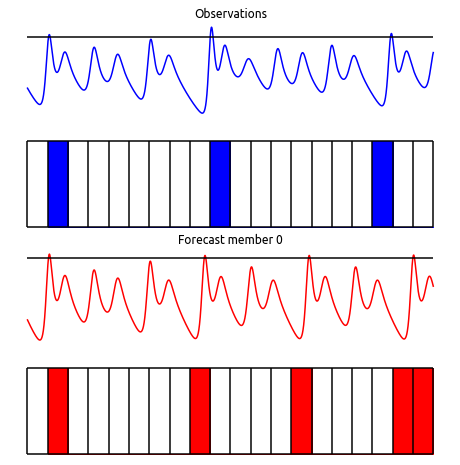

In [9]:
rho = 166.08
pc = 98.5
wsize = 500
tweak_max = 5e-7
raw_fcst = FCST[rho][tweak_max][0,:]
fcst_pw = FCST_PW[rho][tweak_max][pc][wsize][0,:]

# Weirdness with dimensions
raw_obs = OBS[rho]
nnn = 0
if raw_obs.ndim == 2:
    raw_obs = raw_obs[nnn,:]
obs_pw = OBS_PW[rho][pc][wsize][nnn,:]

plot_example(raw_obs,obs_pw,raw_fcst,fcst_pw,
             pc,wsize,f"{rho}",nnn=nnn)

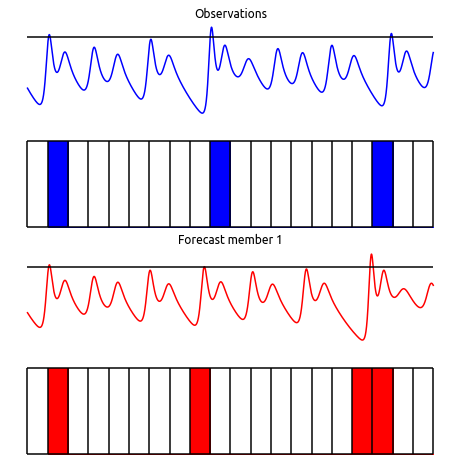

In [10]:
nnn = 1
raw_fcst = FCST[rho][tweak_max][nnn,:]
fcst_pw = FCST_PW[rho][tweak_max][pc][wsize][nnn,:]

plot_example(raw_obs,obs_pw,raw_fcst,fcst_pw,
             pc,wsize,f"{rho}",nnn=nnn)

We note the increasing divergence over time between the three time series. Let's compare the verification of BS and XESS.

In [50]:
def subsample(ensemble,Ne):
    mems = random.sample(range(200),Ne)
    return ensemble[mems,:]

score_components = ["DSC","DSCSS","REL","RELSS","H","UNC","XES","COMPSUM_XES_noH","COMPSUM_XES",
                        "BS","XESS","COMPSUM_XESS_noH","COMPSUM_XESS","BSS",]
feature_list = ['rho','tweak_max','pc','wsize','Ne',]
col_names = feature_list + score_components

# scores = pd.DataFrame()#columns=col_names)
scores = None

Ne_list = [5,10,20,30,40,50,100,150,200]
# Verification
for rho, tweak_max, pc, wsize, Ne in itertools.product(
        rho_list, tweak_max_list, pc_list, wsize_list, Ne_list):
    
    # Randomly select members
    raw_f = FCST_PW[rho][tweak_max][pc][wsize][:,::wsize]
    raw_p = subsample(raw_f,Ne)
    probs = InfoGain.bound(np.mean(raw_p,axis=0),Ne=Ne)
    # obs = OBS_PW[rho][pc][wsize][0,::wsize].astype(int)
    # obs = InfoGain.bound(OBS_PW[rho][pc][wsize][0,::wsize].astype(int),thresh=0.0005)
    obs = InfoGain.bound(OBS_PW[rho][pc][wsize][0,::wsize].astype(float),thresh=0.001)
    # pdb.set_trace()
    IG = InfoGain(f=probs,o=obs)
    BrS = BrierScore(f=probs,o=obs)
    # XES, XES_all = IG.compute_DS()
    # XES, XES_all = IG.compute_XES()
    XES = IG.compute_XES()
    # XESS = IG.compute_DSS()
    XESS = IG.compute_XESS()
    
    DSC = IG.compute_DSC()
    REL = IG.compute_REL()
    UNC = IG.compute_UNC()
    DSCSS = DSC/UNC
    RELSS = REL/UNC
    H = IG.compute_H()

    # Compare with adding components?    
    COMPSUM_XES = IG.compute_XES()
    COMPSUM_XES_noH = IG.compute_XES(with_H=False,from_components=True)

    COMPSUM_XESS = IG.compute_XESS()
    COMPSUM_XESS_noH = IG.compute_XESS(with_H=False,from_components=True)
    
    # BS = compute_BS(f=probs,o=obs)
    BS = BrS.compute_BS()
    # BSS = compute_BSS(f=probs,o=obs)
    BSS = BrS.compute_BSS()

    # pd.DataFrame({'f':probs,'o':obs,'DS_t':DS_all}).head(10)
    # new_df = pd.DataFrame.from_records(list(
    new_df = pd.DataFrame.from_dict(
                    {'rho':rho,'tweak_max':tweak_max*1e8,
                          'pc':pc,'wsize':wsize,'Ne':Ne,'COMPSUM_XES':COMPSUM_XES,
                            'XES':XES,'XESS':XESS,"H":H,'UNC':UNC,'REL':REL,
                           'DSC':DSC,'DSCSS':DSCSS,'RELSS':RELSS,
                            'BS':BS,'BSS':BSS,"COMPSUM_XESS":COMPSUM_XESS,
                           "COMPSUM_XES_noH":COMPSUM_XES_noH,
                           "COMPSUM_XESS_noH":COMPSUM_XESS_noH},orient="index").T
    if scores is None:
        scores = new_df
    else:
        scores = pd.concat([scores, new_df],axis=0,ignore_index=True)
    
scores['wsize'] = scores['wsize'].astype('int16')
scores['tweak_max'] = scores['tweak_max'].astype('int16')
scores['Ne'] = scores['Ne'].astype('int16')
# display(scores)

In [51]:
def visualise_scores(ax,scores,diag,score,title_cap):
    cl = copy.copy(col_names)
    cl.remove(diag)
    diag_vals = scores[diag].unique()
    data = np.zeros([len(diag_vals),len(rho_list)])
    for ndv,dv in enumerate(diag_vals):
        for nrho, rho in enumerate(rho_list):
            sub_df = scores[(scores[diag]==dv) & (scores['rho']==rho)]
            data[ndv,nrho] = sub_df[score].mean() 
    
    # fig,ax = plt.subplots(1,figsize=(7,7))
    x = np.arange(len(diag_vals))
    ax.bar(x-0.3,data[:,0],width=0.1,color='r',align='center',label=rho_list[0])
    ax.bar(x-0.1,data[:,1],width=0.1,color='g',align='center',label=rho_list[1])
    ax.bar(x+0.1,data[:,2],width=0.1,color='b',align='center',label=rho_list[2])
    #ax.bar(x+0.3,data[:,3],width=0.1,color='r',align='center',label=rho_list[2])
    
    ax.plot(x-0.3,data[:,0],color='r')
    ax.plot(x-0.1,data[:,1],color='g')
    ax.plot(x+0.1,data[:,2],color='b')
    #ax.plot(x+0.3,data[:,3],color='r')
    
    ax.hlines(y=0,xmin=0,xmax=x[-1],color='k')    
    ax.set_xticks(x)
    if diag.endswith("SS"):
        ylab = "Skill Score"
    else:
        ylab = "Entropy (bits)"
    ax.set_ylabel(ylab)
    ax.set_xticklabels(diag_vals)
    ax.legend(facecolor='lightblue')
    
    ax.set_title(f"({title_cap}) {score} with respect to {diag}",**ff)
    # display(fig)
    # pdb.set_trace()
    return ax


In [52]:
# for bar_score in score_components:#bar_score = "DSC"
def plot_component(bar_score):
    fig,axes = plt.subplots(ncols=2,nrows=2,figsize=(10,8))
    _ = visualise_scores(axes.flat[0],scores,"Ne",bar_score,"a")
    _ = visualise_scores(axes.flat[1],scores,"tweak_max",bar_score,"b")
    _ = visualise_scores(axes.flat[2],scores,"wsize",bar_score,"c")
    _ = visualise_scores(axes.flat[3],scores,"pc",bar_score,"d")
    return

score_itr = iter(score_components)

(Explain DSCSS and RELSS, Toth paper?)

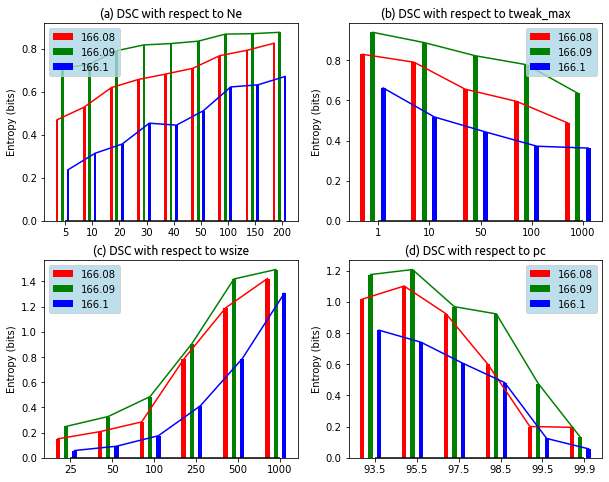

In [53]:
plot_component(next(score_itr))

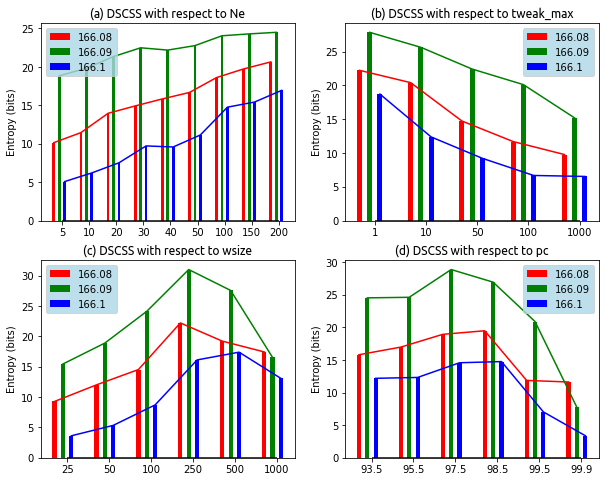

In [54]:
plot_component(next(score_itr))

As ensemble membership increases, increasing useful information (DSC, DSCSS) is acquired by the EFS. We note the diminishing returns as membership increases. As IC error increases, DSCSS understandably decreases. As larger windowing is used DSC is larger. As the rarity of the event increases, the useful information acquired markedly drops. However, the rarer the event, the more sensitive the score to an event, and the larger the range of information loss/gain (bimodal).

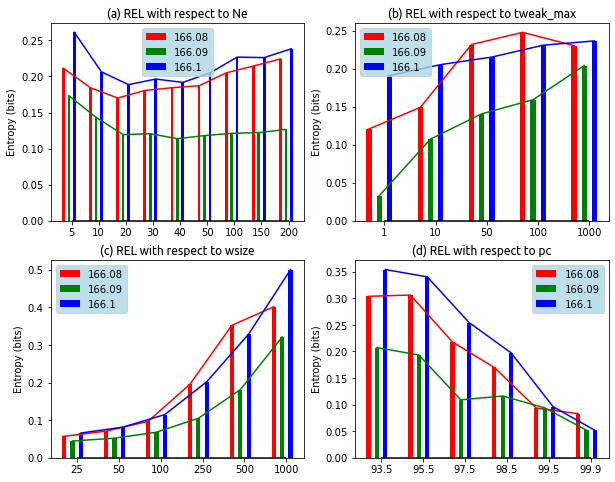

In [55]:
plot_component(next(score_itr))

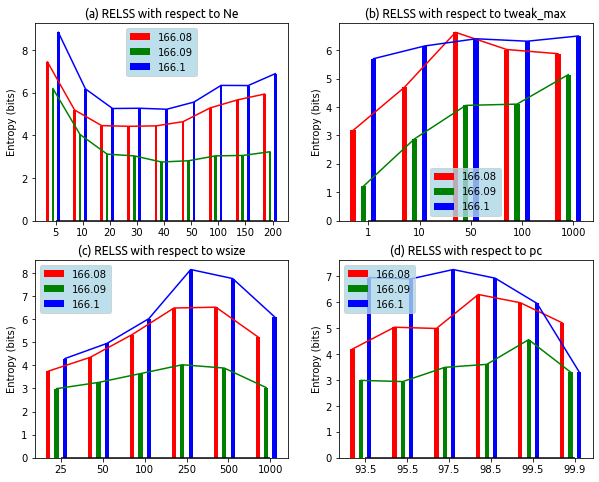

In [56]:
plot_component(next(score_itr))

Reliability error (REL) increases with ensemble membership, just as DSC, as more members increase the chance the individual ensemble member has delivered erroneous information. If DSC > REL (or DSCSS > RELSS), erroneous information does not completely erode the useful information acquired, and hence information is gained.

Reliability error increases with IC error, though it varies highly with regime ($\rho$). This is seen in RELSS, and hence is independent of inherent uncertainty (UNC), and suggests the calibration error is a function of the flow. The lowest REL error occurs at smaller window sizes, though the $\rho = 166.08$ and $= 166.09$ regimes show a minimum near 50 and 100 unit times, respectively. This is analgous to identifying the smallest skillful scale: evaluating data without time--space tolerance will appear poor due to a multitude of phase errors. The variation of optimal window size with regime reiterates the need to evaluate on numerous time--space scales.

Finally, REL error also has a minimum around the 99th percentile. For events rarer than this, error increases rapidly, again potentially due to the low sample size for this percentile. A rarer event requires more data points to evaluate average surprise appropriately. It may therefore be useful to preserve surprise or XES/XESS per epoch $\alpha$ in a time series to identify events that were best or worst for removing surprise.

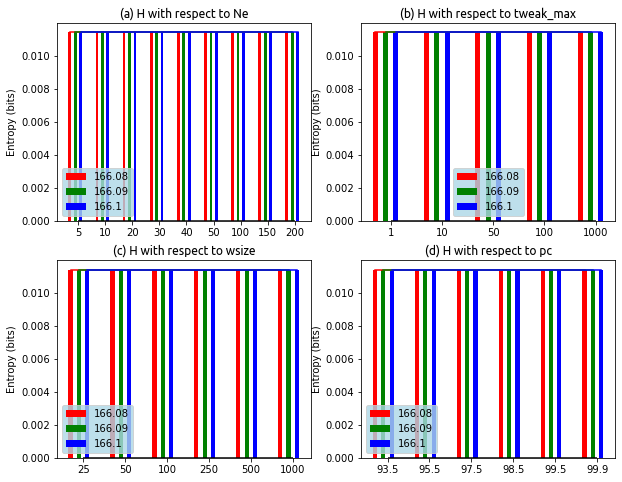

In [57]:
plot_component(next(score_itr))

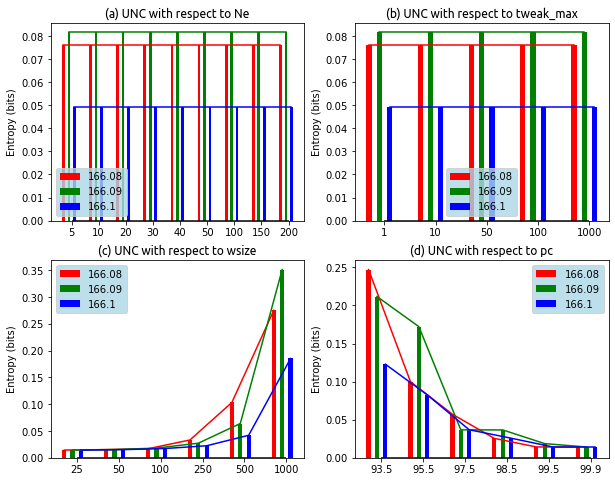

In [58]:
plot_component(next(score_itr))

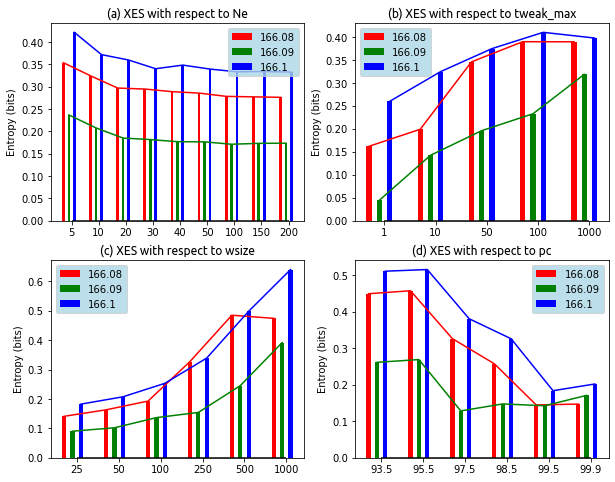

In [59]:
plot_component(next(score_itr))

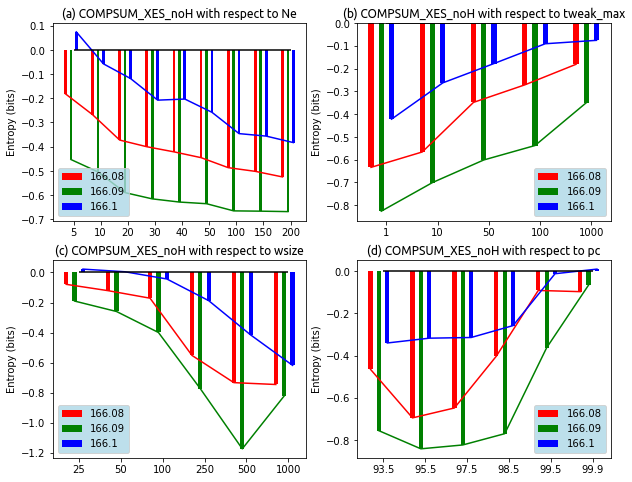

In [60]:
plot_component(next(score_itr))

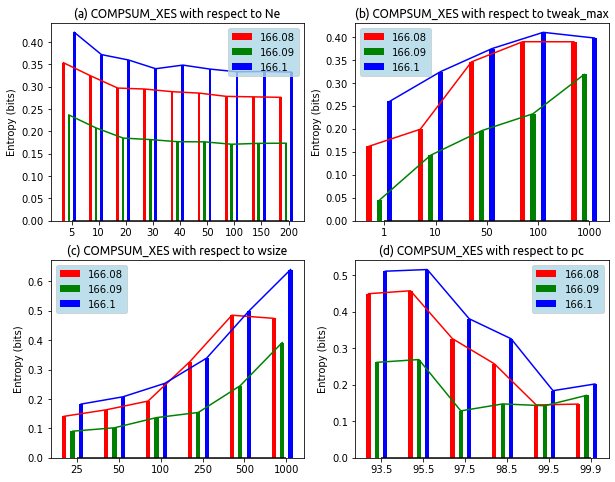

In [61]:
plot_component(next(score_itr))

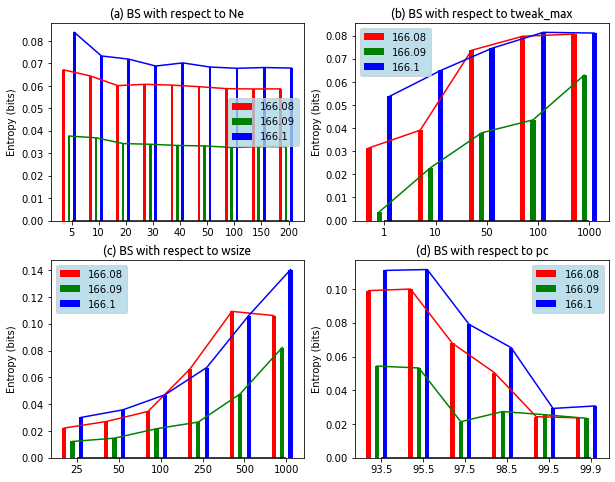

In [62]:
plot_component(next(score_itr))

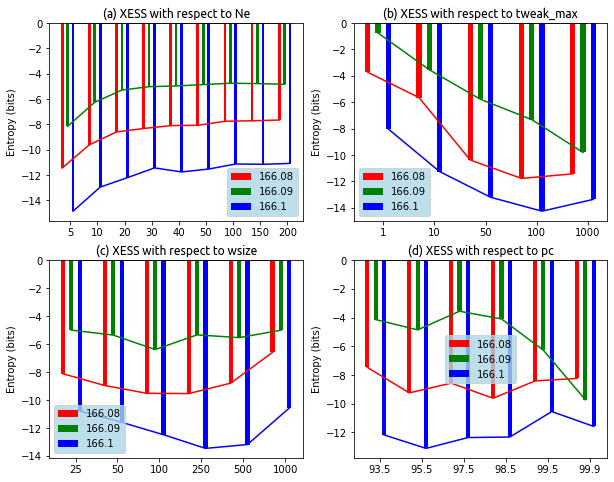

In [63]:
plot_component(next(score_itr))

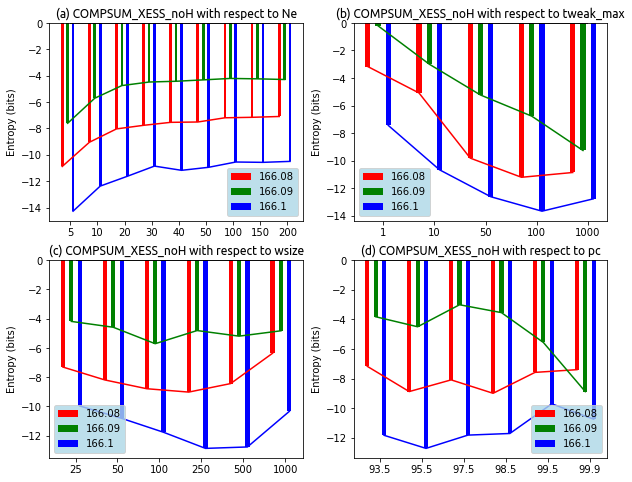

In [64]:
plot_component(next(score_itr))

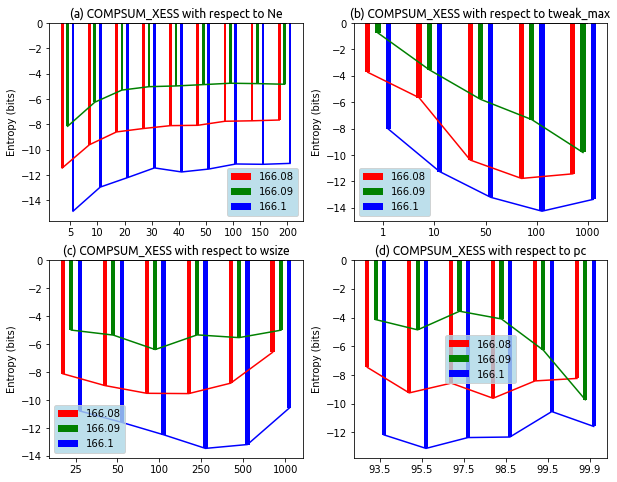

In [65]:
plot_component(next(score_itr))

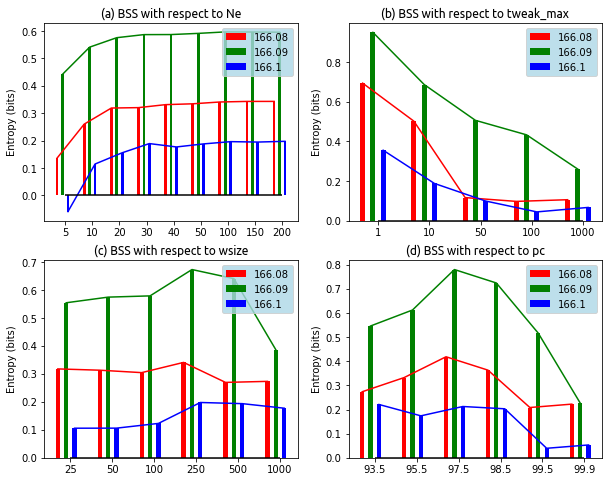

In [66]:
plot_component(next(score_itr))

Comparing BSS and XESS, we see that XESS is more sensitive to poor probabilities than BSS for a small number of ensemble members. The two scores are similar for evaluating skill with respect to IC error and window size. But at extreme percentiles (d), the XESS punishes poor forecasts more severely in the top percentile. It is this non-negligible discrepancy, coupled with the mathematical support of information theory, that supports use of XES and XESS especially in applications where high value is placed on useful information about rare events (i.e., usually high-impact hazards). For instance, forecasting extreme events such as extreme percentile values for rotating supercells may be more accurately evaluated with information theory.

Hence, information gain is the difference between prior (naïve) and posterior uncertainty. The prior uncertainty may simply be UNC; alternatively, we discuss how a prior estimate of uncertainty can be computed from a time series to form a rate of information loss (Kolmogorov-Sinai Entropy or $H_\mu$; ref). Hence, we can form an information "stream" from naivity to the end-user's decision, whereby the EFS, human forecasters, emergency managers, etc represent "information dams". At each dam, the goal is to reduce uncertainty and maximise information gain. The components can be conserved throughout the flow of information.

### Summary of repercussions
Here:

- Scores based on BS, like FSS/eFSS, has the same problem as BS. Can just switch the scoring rule from MSE to XES
- Next
    
Blah.


Some definitions:

| Symbol| Meaning |
| ------ | ------- |
| $N_e$    | Ensemble membership |
| $N_\alpha$ | Number of "epochs" or "unit time steps" |
| $\tau$ | Total time (sec) |
| $H$ | Average entropy or average surprise |
| $S$ | Self-information or event surprise (bits) |
| $H_\times$ | Cross-entropy (bits) |
| $\textrm{IG}$ | Information gain (bits) |
| $I(x{;}y)$ | Mutual information between $x$ and $y$ |
| $$~D_{KL}(x\|y)$$ | Kullback-Liebler Divergence between $x$ and $y$ |
| $f$ | Forecasted probability of event |
| $o$ | Probability that event occurred (i.e., observation) |
| $\mathbf{f}$ | 2-D array of forecast probabilities: $\alpha$ by $i$. |
| $\mathbf{o}$ | 2-D array of probability of occurrence: $\alpha$ by $i$. |
| $\bar{o}$ | Frequency of observed event |
| REL | Reliability of the forecast set|
| DSC | Discrimination (or Brier-type resolution) |
| UNC | Uncertainty of the observed frequency |

Selected mathematical symbols:

| Symbol| Meaning |
| ------ | ------- |
| $\in$   | Belonging to the set of |
| $\mathbb{Z}^+$ | The set of non-zero positive integers 